In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# sklearn library
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer,KNNImputer
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_auc_score,log_loss,accuracy_score,recall_score,balanced_accuracy_score,f1_score
from sklearn.model_selection import cross_val_score,cross_validate,TimeSeriesSplit
from sklearn.model_selection import KFold,RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV,train_test_split,learning_curve
from sklearn.inspection import permutation_importance,partial_dependence,PartialDependenceDisplay
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
# imblearn library
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.pipeline import make_pipeline as make_imblearn_pipeline
# Other classifiers
from xgboost import XGBClassifier

In [2]:
!pip install shap
import shap


[notice] A new release of pip is available: 23.1.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
file_path = './Assignment_Part3_Data.xlsx'
labels = pd.read_excel(file_path, sheet_name='Labels')
features = pd.read_excel(file_path, sheet_name='Features')
variable_description = pd.read_excel(file_path, sheet_name='Variable Description')

## Data Cleaning and Exploration

### Missing Values & Outlier Detection

In [4]:
print(features.isnull().sum())
print(labels.isnull().sum())

iso3           0
iso2          62
imfn           0
country        0
region         0
income         0
year           0
si01        9959
si02       10798
si03       10881
si04        4715
si05       10779
si06       10020
si07       11032
sm01       10917
oi01        9938
oi02        4803
dtype: int64
iso3                0
Country             0
Year                0
Banking Crisis    215
dtype: int64


There are 62 missing values in variables `iso2`, 215 missing values in `Banking Crisis`, and more than 9000 each in the variables`si01-07`,`sm01`,`oi01-02`. 

In [5]:
pd.set_option('display.max_rows', None)
missing_values_by_year = features.groupby('year').apply(lambda x: x.isnull().sum())

print(missing_values_by_year)

      iso3  iso2  imfn  country  region  income  year  si01  si02  si03  si04  \
year                                                                            
1960     0     1     0        0       0       0     0   214   214   214   148   
1961     0     1     0        0       0       0     0   214   214   214   141   
1962     0     1     0        0       0       0     0   214   214   214   139   
1963     0     1     0        0       0       0     0   214   214   214   134   
1964     0     1     0        0       0       0     0   214   214   214   130   
1965     0     1     0        0       0       0     0   214   214   214   125   
1966     0     1     0        0       0       0     0   214   214   214   122   
1967     0     1     0        0       0       0     0   214   214   214   120   
1968     0     1     0        0       0       0     0   214   214   214   118   
1969     0     1     0        0       0       0     0   214   214   214   117   
1970     0     1     0      

In [6]:
missing_values_rows = labels[labels['Banking Crisis'].isna()]
print(missing_values_rows)

      iso3                   Country  Year  Banking Crisis
35     DZA                   Algeria  2015             NaN
36     DZA                   Algeria  2016             NaN
72     AGO                    Angola  2015             NaN
73     AGO                    Angola  2016             NaN
109    ARG                 Argentina  2015             NaN
110    ARG                 Argentina  2016             NaN
146    AUS                 Australia  2015             NaN
147    AUS                 Australia  2016             NaN
183    AUT                   Austria  2015             NaN
184    AUT                   Austria  2016             NaN
220    BEL                   Belgium  2015             NaN
221    BEL                   Belgium  2016             NaN
257    BOL                   Bolivia  2015             NaN
258    BOL                   Bolivia  2016             NaN
294    BRA                    Brazil  2015             NaN
295    BRA                    Brazil  2016             N

In [7]:
missing_values_iso2 = features[features['iso2'].isna()]
print(missing_values_iso2)

     iso3 iso2  imfn  country              region               income  year  \
8432  NAM  NaN   728  Namibia  Sub-Saharan Africa  Upper middle income  1960   
8433  NAM  NaN   728  Namibia  Sub-Saharan Africa  Upper middle income  1961   
8434  NAM  NaN   728  Namibia  Sub-Saharan Africa  Upper middle income  1962   
8435  NAM  NaN   728  Namibia  Sub-Saharan Africa  Upper middle income  1963   
8436  NAM  NaN   728  Namibia  Sub-Saharan Africa  Upper middle income  1964   
8437  NAM  NaN   728  Namibia  Sub-Saharan Africa  Upper middle income  1965   
8438  NAM  NaN   728  Namibia  Sub-Saharan Africa  Upper middle income  1966   
8439  NAM  NaN   728  Namibia  Sub-Saharan Africa  Upper middle income  1967   
8440  NAM  NaN   728  Namibia  Sub-Saharan Africa  Upper middle income  1968   
8441  NAM  NaN   728  Namibia  Sub-Saharan Africa  Upper middle income  1969   
8442  NAM  NaN   728  Namibia  Sub-Saharan Africa  Upper middle income  1970   
8443  NAM  NaN   728  Namibia  Sub-Sahar

It seems that most of the missing values in the variables`si01-07`,`sm01`,`oi01-02`come from before 2000 and after 2020. Missing values in the label `Banking Crisis` come from year 2015-2016, and two countries: Ireland and Switzerland. The `iso2` of Namibia, which is 'NA', was also wrongly recognized as missing value.

Based on the data covergarge analysis, the period from 2000 to 2014 seems including the least missing values. However, it's important to include the Asian Crisis of 1997 and the Russian financial crisis of 1998 in the time span. Additionally, in order to add new variables of percentage change in Feature Enginerring part, this time period was extend to 1995 to 2014. 

In [8]:
#select 2000 to 2014 as new time periods for each country
features = features[(features['year']>=1999) & (features['year']<=2014)]
labels.rename(columns={'Year': 'year','Country': 'country'}, inplace=True)
labels = labels[(labels['year']>=1999) & (labels['year']<=2014)]
features = labels.merge(features, on=['country','year','iso3'],how='left')

### Other Descriptive Statistics

In [9]:
numerical_features = features[['si01','si02','si03','si04','si05','si06','si07','sm01','oi01','oi02']]
pd.set_option('display.max_columns', None)
print("UNIVARIATE DESCRIPTIVE STAT using pandas\n",numerical_features.describe(include='all').T)
print("\n SKEWNESS\n",features.skew())
print("\n FISHER'S KURTOSIS\n",features.kurt())

UNIVARIATE DESCRIPTIVE STAT using pandas
       count        mean        std        min        25%        50%  \
si01  869.0   16.186153   9.344565  -0.187225   9.420330  14.830430   
si02  841.0    5.867103   6.609036   0.100000   1.748612   3.287203   
si03  825.0    8.342560   3.009844   1.490407   5.900000   8.100000   
si04  946.0  110.232164  54.530003  13.374820  75.515457  98.931255   
si05  847.0   14.609356   3.517598   1.754749  12.300000  13.934590   
si06  864.0   33.459151  18.980443   0.379993  19.160643  29.331045   
si07  758.0   80.285234  46.682629   9.862677  47.700001  66.800003   
sm01  709.0   21.014664   9.940121   3.898269  14.071190  19.767020   
oi01  873.0   65.800237  19.349022  21.450820  50.529870  65.031520   
oi02  942.0   55.490961  35.659568   0.334058  29.511520  47.750070   

             75%         max  
si01   20.069710   43.737300  
si02    7.200000   38.599998  
si03   10.200000   23.677498  
si04  129.501525  370.900200  
si05   16.449376   42

The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
The default value of numeric_only in DataFrame.kurt is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


### Handling Missing Values 

In [10]:
features_cleaned = features.dropna(subset=['Banking Crisis'])
features_cleaned = features_cleaned.dropna(subset=['imfn'])
features_cleaned.isnull().sum()

iso3                0
country             0
year                0
Banking Crisis      0
iso2                0
imfn                0
region              0
income              0
si01              136
si02              167
si03              183
si04               60
si05              161
si06              142
si07              247
sm01              295
oi01              133
oi02               64
dtype: int64

In [11]:
numerical_features = features_cleaned[['si01','si02','si03','si04','si05','si06','si07','sm01','oi01','oi02']]
non_numerical_features = features_cleaned.drop(columns=numerical_features)

# Use KNN imputation
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(numerical_features)
imputed_features = pd.DataFrame(imputed_data, columns=numerical_features.columns)
features_cleaned = pd.concat([non_numerical_features.reset_index(drop=True),imputed_features.reset_index(drop=True)], axis=1)
features_cleaned.isnull().sum()

iso3              0
country           0
year              0
Banking Crisis    0
iso2              0
imfn              0
region            0
income            0
si01              0
si02              0
si03              0
si04              0
si05              0
si06              0
si07              0
sm01              0
oi01              0
oi02              0
dtype: int64

For missing values in Banking Crisis and imfn, I drop off them directly. For missing values in the rest of the features, I utilized KNN imputation, as the nearer data shows similar characteristics.

### Removing Outliers

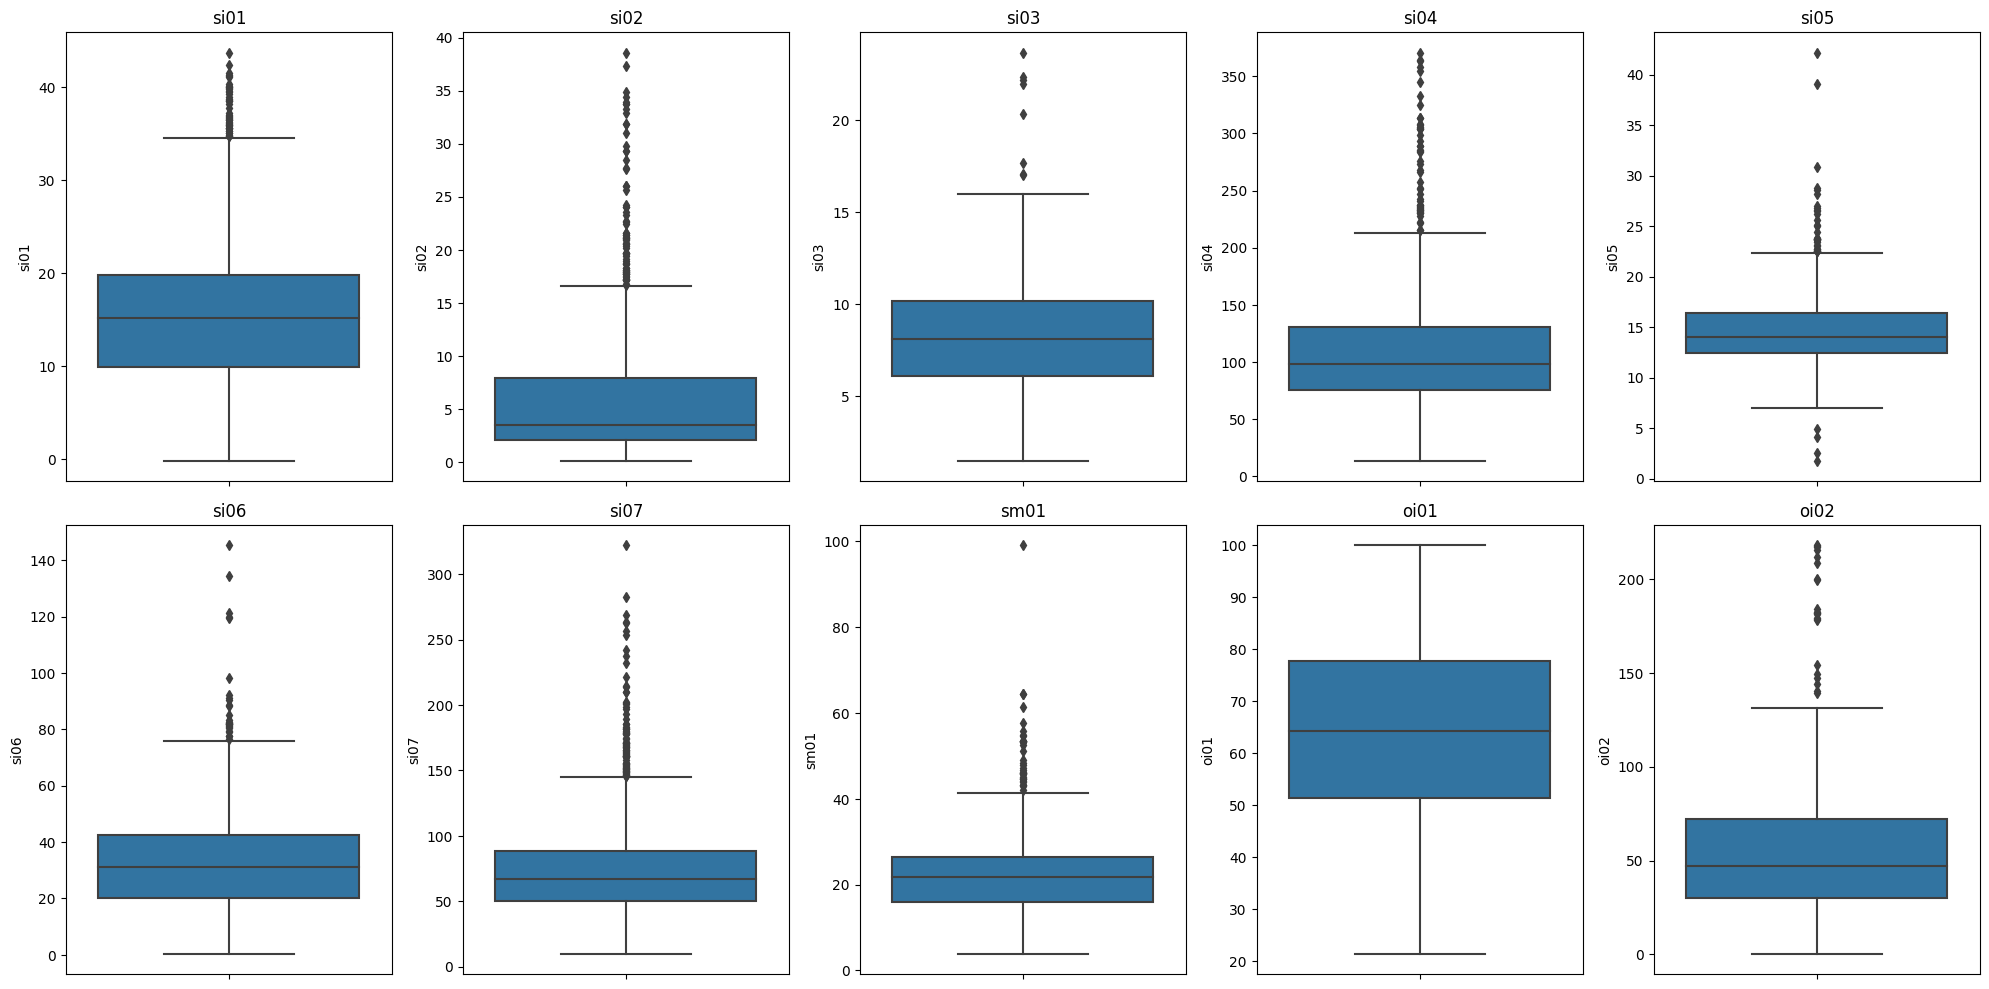

In [12]:
#detect outliers for numerical features
plt.figure(figsize=(20, 10))

for i, feature in enumerate(numerical_features.columns):
    plt.subplot(2, 5, i+1)  
    sns.boxplot(y=feature, data=features_cleaned)
    plt.title(feature)

plt.tight_layout()
plt.show()

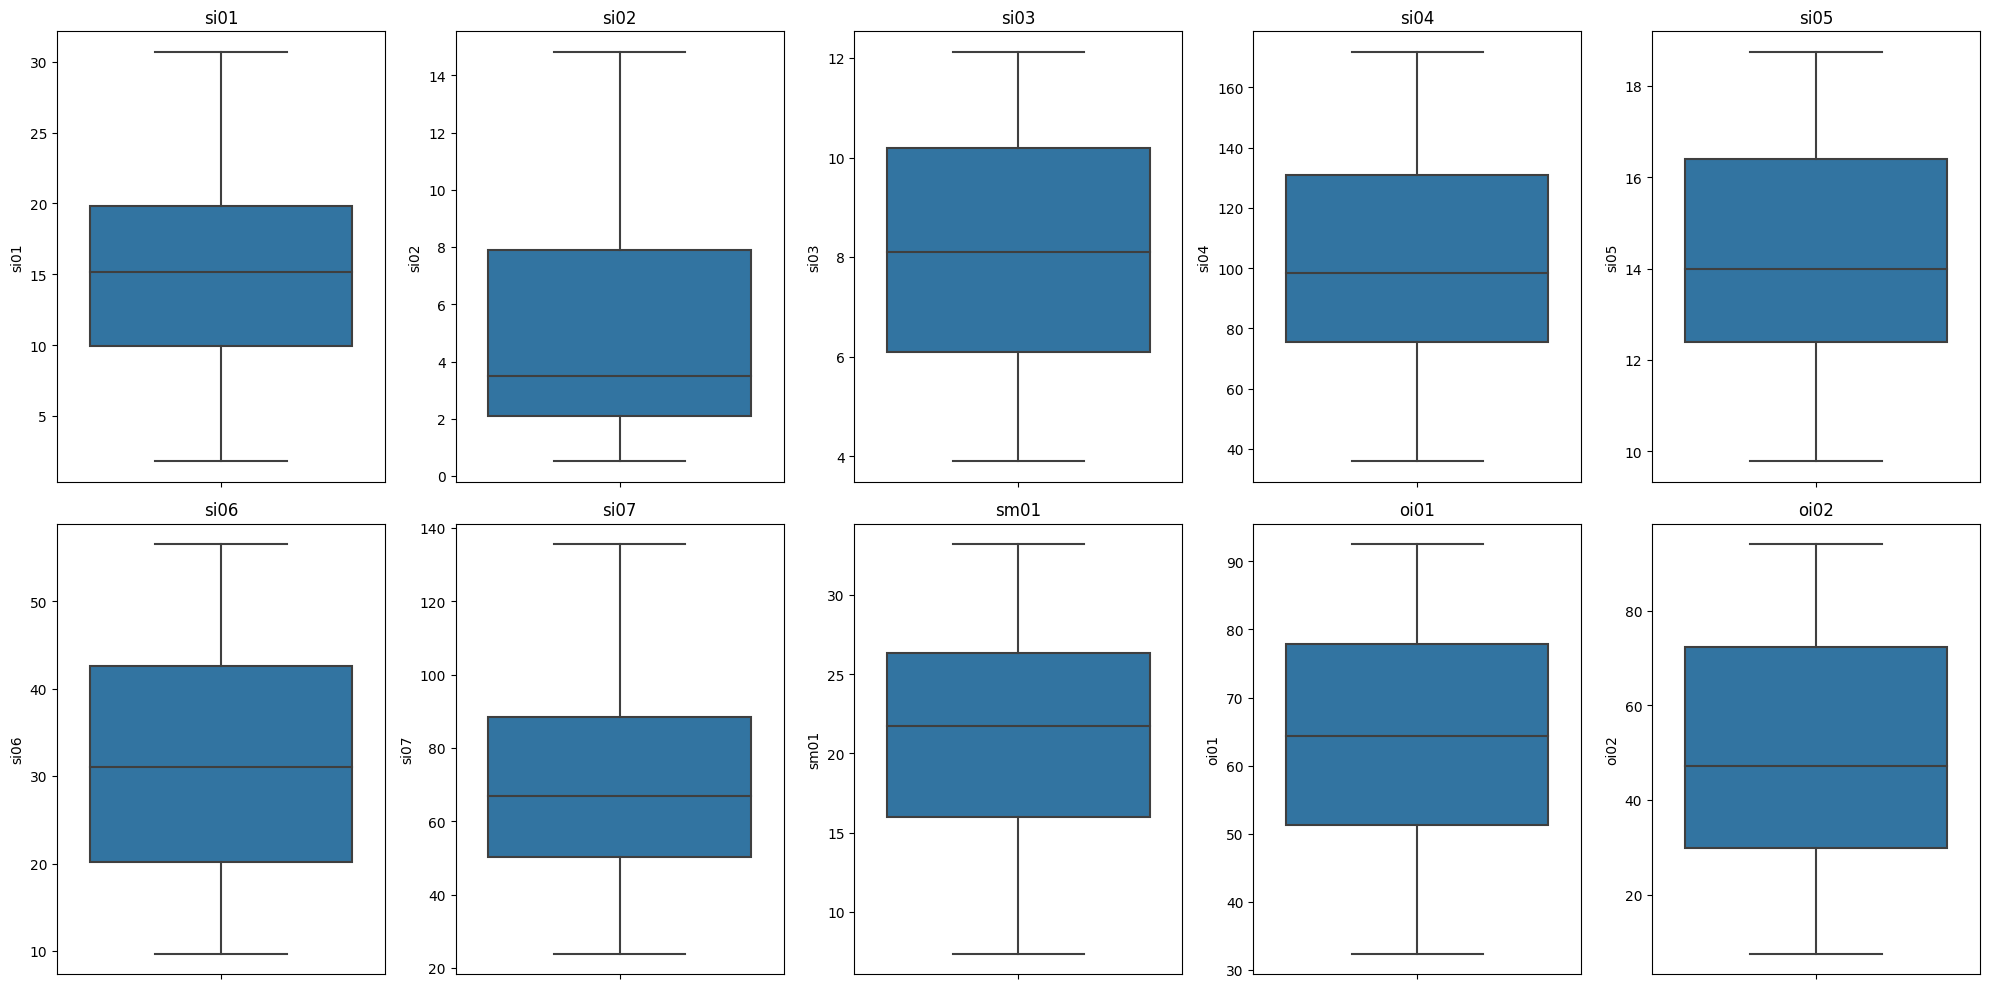

In [13]:
winsorized_features = imputed_features.apply(lambda x: winsorize(x, limits=[0.02, 0.1]))

features_cleaned[imputed_features.columns] = winsorized_features

plt.figure(figsize=(20, 10))

for i, feature in enumerate(imputed_features.columns):
    plt.subplot(2, 5, i+1)  
    sns.boxplot(y=feature, data=features_cleaned)
    plt.title(feature)

plt.tight_layout()
plt.show()

Many subplots indicate that outliers are predominantly concentrated at higher values. For instance, `si02`, `si04` ,`si07`, `si05` and `oi02` exhibit many high-end outliers. In contrast, `si05` have fewer outliers at the lower end. The limits parameter in scipy.stats.mstats.winsorize function represents the lower and upper percentiles to be trimmed. According to the Box plots, I chose limits=[0.02,0.1], meaning trimming the lowest 2% and highest 10% of the data points.

## Feature Engineering

### Encoding

In [14]:
ohe = OneHotEncoder(sparse=False, drop='first') 
categorical_features = features_cleaned[['region', 'income']]
ohe_features = ohe.fit_transform(categorical_features)

ohe_feature_names = ohe.get_feature_names_out(['region', 'income'])
ohe_df = pd.DataFrame(ohe_features, columns=ohe_feature_names, index=features_cleaned.index)

features_encoded = pd.concat([features_cleaned.drop(['region', 'income'], axis=1), ohe_df], axis=1)
features_encoded.head()

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


,iso3,country,year,Banking Crisis,iso2,imfn,si01,si02,si03,si04,si05,si06,si07,sm01,oi01,oi02,region_Europe & Central Asia,region_Latin America & Caribbean,region_Middle East & North Africa,region_North America,region_South Asia,region_Sub-Saharan Africa,income_Low income,income_Lower middle income,income_Upper middle income
0,DZA,Algeria,1999,0.0,DZ,612.0,9.389040,13.924937,8.300189,35.89462,18.742578,46.994552,66.448194,33.184482,80.741102,28.67068,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,DZA,Algeria,2000,0.0,DZ,612.0,8.788944,3.980000,5.720000,35.89462,11.260000,14.440750,54.579998,20.170148,72.854110,26.14624,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,DZA,Algeria,2001,0.0,DZ,612.0,9.361630,3.980000,5.000000,35.89462,11.260000,27.287590,76.179996,20.170148,73.391310,40.59793,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,DZA,Algeria,2002,0.0,DZ,612.0,10.529070,3.560000,6.500000,35.89462,11.220000,34.467550,77.079996,20.296934,74.391880,45.39818,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,DZA,Algeria,2003,0.0,DZ,612.0,10.325340,2.860000,5.140000,35.89462,11.820000,29.126770,54.579998,28.333718,86.357870,45.21692,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


For our current scenario, encoding region and income with OneHotEncoder is chosen because these features are unordered, and we want to retain the information in these features without introducing potential assumptions of order. I think this is helpful for most tree-based models and linear models, as they do not inherently interpret mathematical operations between categories.

### New Features

Changes in variables are important to analyze financial and macroeconomic data that related to time series analysis. Rates of change may include more valuable information than absolute values, as they reflect dynamic shifts in economic indicators. 

Among all the variables, I selected 5 of them, `si03`,`si04`,`si05`,`si06`,`oi02`.

In [15]:
features_encoded['si03_change'] = features_encoded.groupby('iso3')['si03'].pct_change()
features_encoded['si04_change'] = features_encoded.groupby('iso3')['si04'].pct_change()
features_encoded['si05_change'] = features_encoded.groupby('iso3')['si05'].pct_change()
features_encoded['si06_change'] = features_encoded.groupby('iso3')['si06'].pct_change()
features_encoded['oi02_change'] = features_encoded.groupby('iso3')['oi02'].pct_change()

In [16]:
features_encoded = features_encoded[features_encoded['year']!=1999].reset_index(drop=True)
features_encoded.isnull().sum()

iso3                                 0
country                              0
year                                 0
Banking Crisis                       0
iso2                                 0
imfn                                 0
si01                                 0
si02                                 0
si03                                 0
si04                                 0
si05                                 0
si06                                 0
si07                                 0
sm01                                 0
oi01                                 0
oi02                                 0
region_Europe & Central Asia         0
region_Latin America & Caribbean     0
region_Middle East & North Africa    0
region_North America                 0
region_South Asia                    0
region_Sub-Saharan Africa            0
income_Low income                    0
income_Lower middle income           0
income_Upper middle income           0
si03_change              

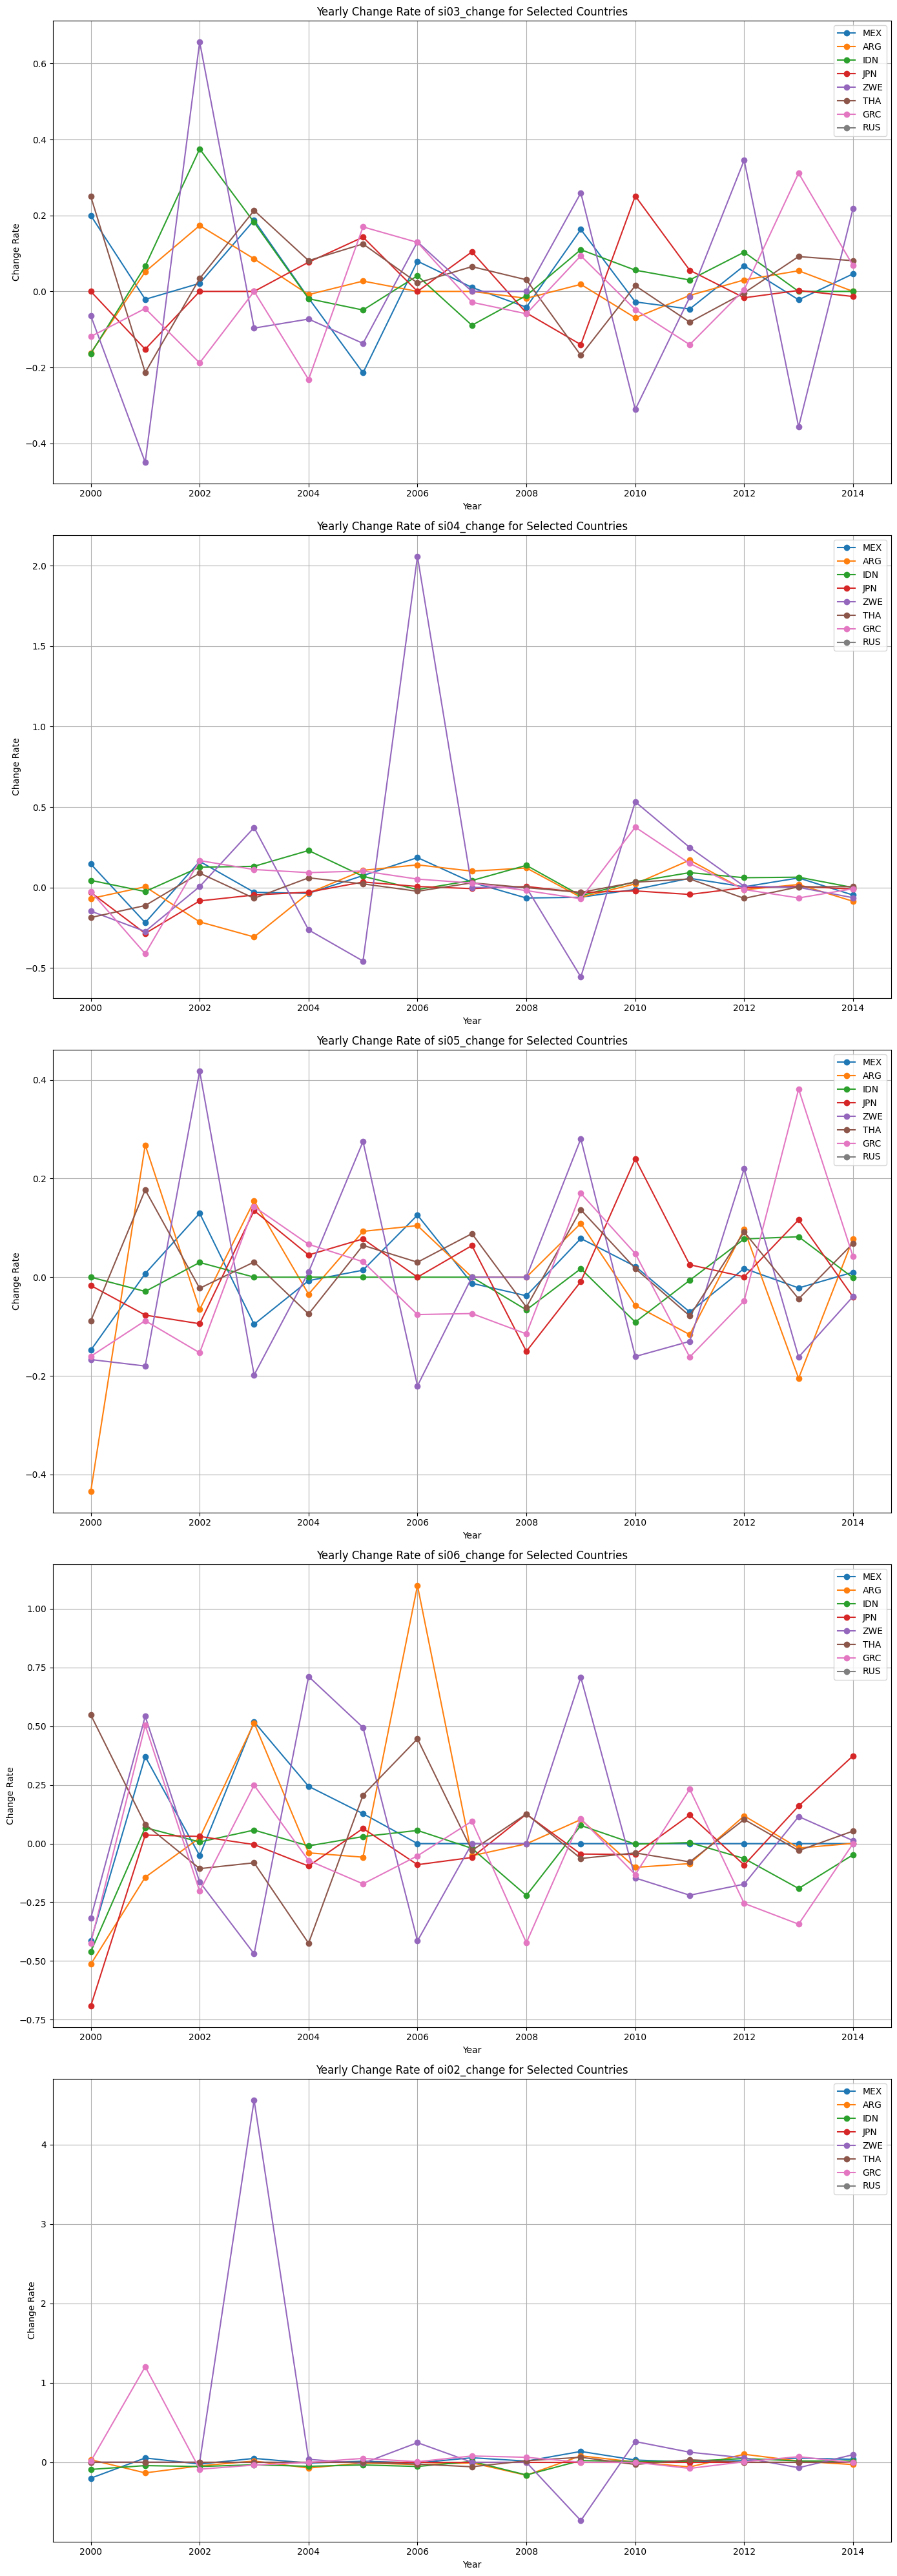

In [17]:
# Variables and countries you want to plot
variables_to_plot = ['si03_change', 'si04_change', 'si05_change', 'si06_change', 'oi02_change']
selected_countries = ['MEX', 'ARG', 'IDN', 'JPN', 'ZWE', 'THA', 'GRC', 'RUS']

# Setup the figure and axes for subplots
fig, axes = plt.subplots(len(variables_to_plot), 1, figsize=(14, 40))

# Loop through each variable to plot
for index, variable_to_plot in enumerate(variables_to_plot):
    for country in selected_countries:
        country_data = features_encoded[features_encoded['iso3'] == country]
        axes[index].plot(country_data['year'], country_data[variable_to_plot], marker='o', linestyle='-', label=country)
    
    axes[index].set_title(f'Yearly Change Rate of {variable_to_plot} for Selected Countries')
    axes[index].set_xlabel('Year')
    axes[index].set_ylabel('Change Rate')
    axes[index].legend()
    axes[index].grid(True)

plt.tight_layout()
plt.show()


The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


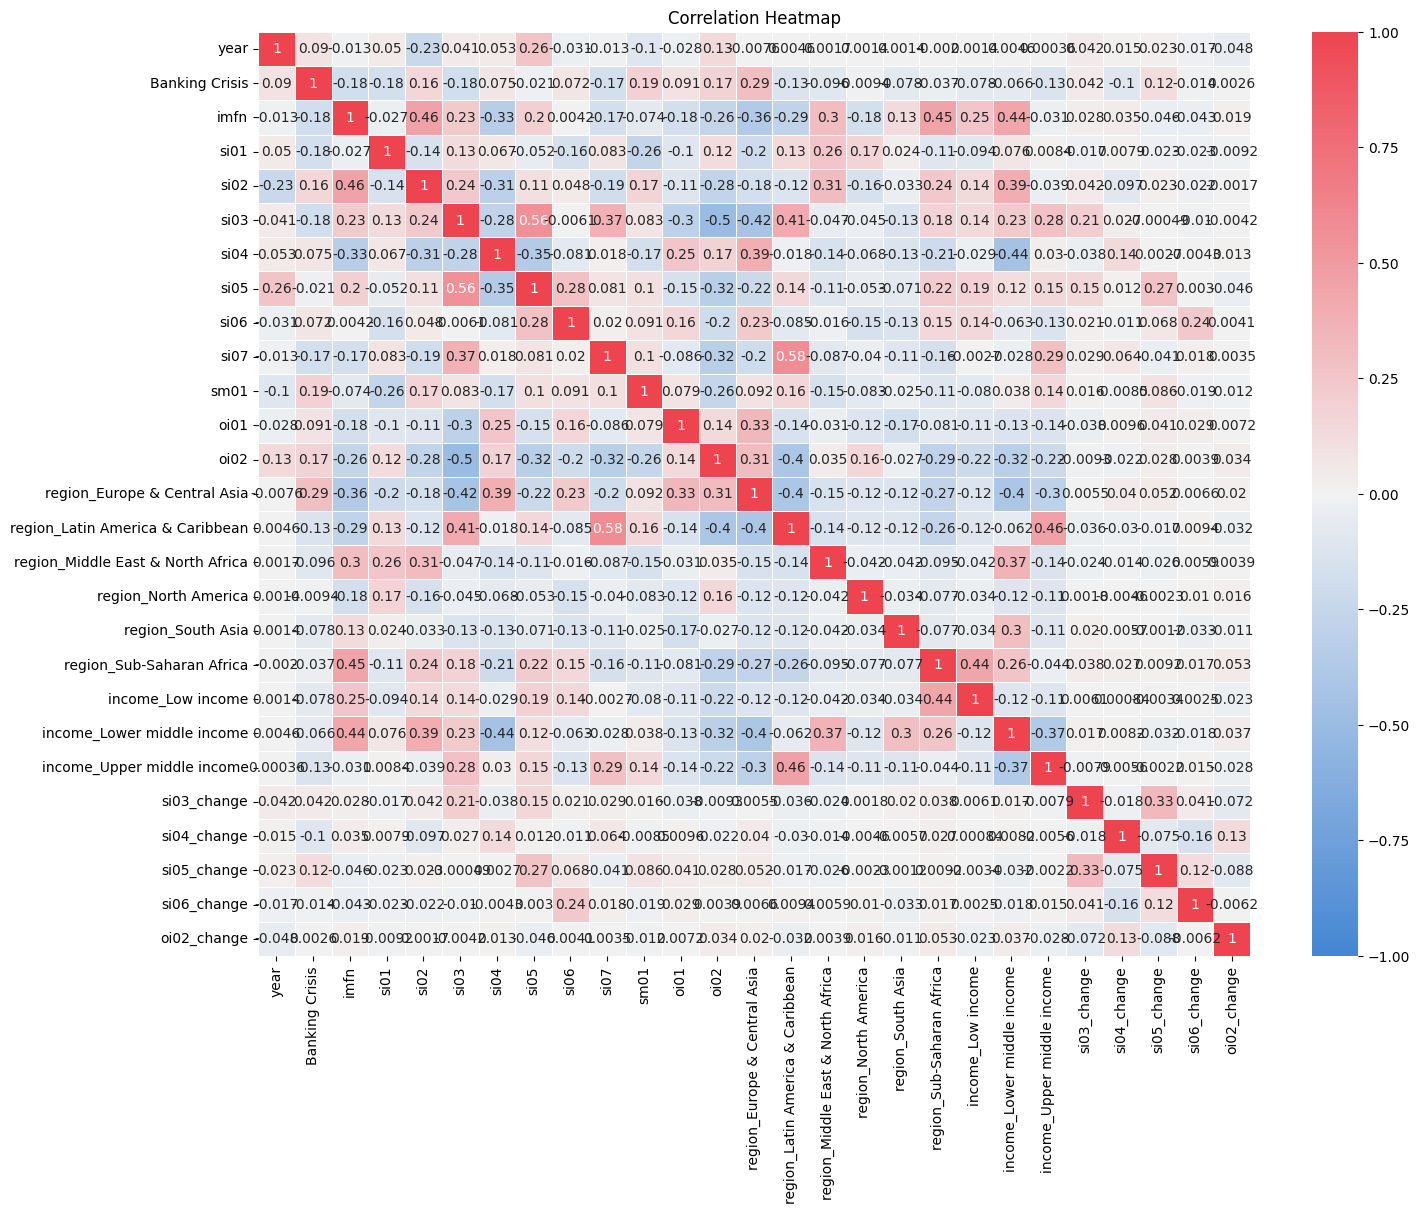

In [18]:
#Correlation Matrix as a Heatmap

plt.figure(figsize = (16,12))
cmap = sns.diverging_palette(250, 10, l = 55, s = 80, n=9, as_cmap = True)
sns.heatmap((features_encoded).corr(), vmin = -1, vmax = 1, annot = True, cmap = cmap, lw = .5, linecolor = 'white')
plt.title("Correlation Heatmap")

plt.show()

### Spliting Dataset and Addressing Imbalance

In [19]:
print(features_encoded['Banking Crisis'].value_counts())

0.0    772
1.0    138
Name: Banking Crisis, dtype: int64


In [20]:
# #randomly delete 400 rows which Banking Crisis = 0
# indices_to_remove = features_encoded.index[features_encoded['Banking Crisis'] == 0]
# random_indices = np.random.choice(indices_to_remove, size=400, replace=False)
# features_encoded = features_encoded.drop(random_indices)
# features_encoded.reset_index(drop=True, inplace=True)

As an attempt to address the imbalance issue, I removed some data with a label of 0. However, it resulted in poor performance with an AUC of only 0.7. Therefore, alternative approaches are being explored.

In [21]:
features_encoded.reset_index(drop=True, inplace=True)
X = features_encoded.drop(['Banking Crisis','country','iso3','iso2','imfn'],axis=1)
y = features_encoded[['Banking Crisis','year']]

Removing 'country' and 'year' from model training data is under the consideration of generalization and interpretability. These fields can increase noise and limit the model's ability to apply learned patterns to new, unseen data. One-hot encoding 'country' inflates the number of features, complicating training and adding minimal information. Predictions also become less understandable when tied to specific countries or years rather than broader trends or indicators.

In [22]:
X_train = X[X['year'] < 2014]
X_test = X[X['year'] == 2014]
y_train = y[y['year'] < 2014]
y_test = y[y['year'] == 2014]
# Shape of X_train
X_train.shape

(851, 25)

In [23]:
data_frames = [X_train, X_test, y_train, y_test, y, X]

for df in data_frames:
    if 'year' in df.columns:  # 确保'year'列存在
        df.drop(['year'], axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [24]:
X_test.head()

,si01,si02,si03,si04,si05,si06,si07,sm01,oi01,oi02,region_Europe & Central Asia,region_Latin America & Caribbean,region_Middle East & North Africa,region_North America,region_South Asia,region_Sub-Saharan Africa,income_Low income,income_Lower middle income,income_Upper middle income,si03_change,si04_change,si05_change,si06_change,oi02_change
14,18.820340,9.934961,8.331513,37.06756,15.791741,43.89904,61.776379,22.855056,66.80672,49.44395,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.114175,-0.023520,-0.157440,-0.100809,0.138634
29,8.564436,4.260000,6.960000,59.79449,13.520000,30.31591,60.379998,22.837104,68.77738,33.25840,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.325375,-0.137252,-0.067207,-0.010180,0.070423
44,8.420600,1.990064,12.120745,71.42828,14.671783,34.42952,135.500000,32.974480,36.61426,18.85372,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,-0.086234,0.077917,0.000821,-0.029524
59,13.489030,1.013845,5.401598,138.77390,12.215585,18.55934,24.468999,11.295670,70.92371,91.76347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018605,0.010955,0.052489,0.032648,0.030779
74,26.820640,3.473374,6.841916,110.12560,16.252921,54.00161,63.247630,16.813140,42.50830,79.16259,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.143255,-0.062464,-0.095519,0.183758,0.008998


In [25]:
# SMOTE (Synthetic Minority Class Oversampling) of training data
smote = SMOTE(random_state=42)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)
# Shape of X_train
print(X_train_SMOTE.shape)
print(y_train_SMOTE.shape)

(1448, 24)
(1448, 1)


In [26]:
# Setting up a standard scaler for the features and analyzing it thereafter
col_names = list(X.columns)
s_scaler = StandardScaler()
X_train_SMOTE_std = s_scaler.fit_transform(X_train_SMOTE)
X_test_std = s_scaler.transform(X_test)

## Model Building

### Models

In [27]:

names = ["Perceptron", "Logistic Regression", "SVM (RBF kernel)", "Decision Tree","Naive Bayes", "k Nearest Neighbors","Random Forest", "XG Boost","AdaBoost"]
classifiers = [
    Perceptron(random_state=1),
    LogisticRegression(),
    SVC(kernel="rbf", C=1),
    DecisionTreeClassifier(max_depth=5),
    GaussianNB(),
    KNeighborsClassifier(3),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, n_estimators=100, max_depth=5),
    AdaBoostClassifier(n_estimators=50, random_state=42)
]

no_folds = 5  # Number of folds desired for cross-validation
tscv = TimeSeriesSplit(n_splits=no_folds)

for name, clf in zip(names, classifiers):
    print('CLASSIFIER: ', name, '\n')
    mean_accuracy = 0.0
    mean_auc = 0.0
    mean_f1 = 0.0
    mean_recall = 0.0
    for fold, (train_index, test_index) in enumerate(tscv.split(X), 1):
        y_new = y.values.ravel()
        X_train_new, X_test_new = X.iloc[train_index], X.iloc[test_index]
        y_train_new, y_test_new = y_new[train_index], y_new[test_index]
        
        sm = SMOTE()
        X_train_SMOTE_new, y_train_SMOTE_new = sm.fit_resample(X_train_new, y_train_new)
        stdsc = StandardScaler()
        X_train_SMOTE_std_new = stdsc.fit_transform(X_train_SMOTE_new)
        X_test_std_new = stdsc.transform(X_test_new)
        clf.fit(X_train_SMOTE_std_new, y_train_SMOTE_new)
        y_pred = clf.predict(X_test_std_new)
        
#         stdsc = StandardScaler()
#         X_train_std = stdsc.fit_transform(X_train)
#         X_test_std = stdsc.transform(X_test)
#         clf.fit(X_train_std, y_train)
#         y_pred = clf.predict(X_test_std)        

        
#         print(f'For fold {fold}:')
#         print(f'Accuracy: {clf.score(X_test_std, y_test)}')
#         print(f'AUC: {roc_auc_score(y_test, y_pred)}')
#         print(f'F1: {f1_score(y_test, y_pred)}')
#         print(f'Recall: {recall_score(y_test, y_pred)}')
        
        mean_accuracy += clf.score(X_test_std_new, y_test_new)
        mean_auc += roc_auc_score(y_test_new, y_pred)
        mean_f1 += f1_score(y_test_new, y_pred)
        mean_recall += recall_score(y_test_new, y_pred)
    
    mean_accuracy /= no_folds
    mean_auc /= no_folds
    mean_f1 /= no_folds
    mean_recall /= no_folds
    
    print(f'Average accuracy: {mean_accuracy:.3f} Average AUC: {mean_auc:.3f} Average F1: {mean_f1:.3f} Average recall: {mean_recall:.3f}\n\n')

CLASSIFIER:  Perceptron 

Average accuracy: 0.754 Average AUC: 0.657 Average F1: 0.389 Average recall: 0.513


CLASSIFIER:  Logistic Regression 

Average accuracy: 0.783 Average AUC: 0.697 Average F1: 0.448 Average recall: 0.563


CLASSIFIER:  SVM (RBF kernel) 

Average accuracy: 0.824 Average AUC: 0.660 Average F1: 0.391 Average recall: 0.400


CLASSIFIER:  Decision Tree 

Average accuracy: 0.777 Average AUC: 0.672 Average F1: 0.389 Average recall: 0.497


CLASSIFIER:  Naive Bayes 

Average accuracy: 0.389 Average AUC: 0.588 Average F1: 0.328 Average recall: 0.867


CLASSIFIER:  k Nearest Neighbors 

Average accuracy: 0.763 Average AUC: 0.658 Average F1: 0.388 Average recall: 0.489


CLASSIFIER:  Random Forest 

Average accuracy: 0.771 Average AUC: 0.634 Average F1: 0.336 Average recall: 0.425


CLASSIFIER:  XG Boost 

Average accuracy: 0.849 Average AUC: 0.677 Average F1: 0.443 Average recall: 0.407


CLASSIFIER:  AdaBoost 

Average accuracy: 0.825 Average AUC: 0.697 Average F1: 0.46

ROC-AUC score is chosen as the primary metrics. Other metrics such as F1, recall, and accuracy are referenced as As auxiliary metrics. Logistic Regression, Random Forest, and XGBoost outperform other classifiers on the metrics performance. By examining the  learning curves, Random Forest and XGBoost has less overfitting problem than Logistic Regression. Below is a horce race between different models: 

**Model1**: time period: 1980(1981)-2014, with change rate variables, with SMOTE
| Classifier | Accuracy | **AUC** | F1 | Recall  |
|----------|----------|----------|---------|--------|
| Logistic Regression  | 0.595  | 0.590  |  0.373     |  0.571      |
| Random Forest |  0.659  | 0.580  |  0.342     |  0.437      |
| XG Boost   |  708  | 0.592  |  0.350     |  0.383      |

**Model2**: time period: 1995(1996)-2014, with change rate variables, with SMOTE
| Classifier | Accuracy | AUC | F1 | Recall  |
|----------|----------|----------|---------|--------|
| Logistic Regression  | 0.707  | 0.686   |  0.453     |  0.647      |
| Random Forest | 0.779   | 0.640  |   0.396     | 0.409 |
| XG Boost   | 0.782  | 0.680   |  0.452    |  0.500     |

**Model3**: time period: 1999(2000)-2014, with pchange rate variables, with SMOTE
| Classifier | Accuracy | AUC | F1 | Recall  |
|----------|----------|----------|---------|--------|
| Logistic Regression  | 0.766  | 0.687   |  0.426     |  0.563      |
| Random Forest | 0.795   | 0.667 |   0.403     | 0.470 |
| **XG Boost**   | 0.834  | 0.684   |  0.444   |  0.451     |

**Model4**: time period: 2000-2014, without change rate variables, with SMOTE
| Classifier | Accuracy | AUC | F1 | Recall  |
|----------|----------|----------|---------|--------|
| Logistic Regression  | 0.744  | 0.677  |  0.418    |  0.570     |  
| Random Forest | 0.749   | 0.634  |   0.376     | 0.452 | 
| XG Boost   | 0.812  | 0.678   |  0.426    |  0.458     |  

**Model5**: time period: 1999-2014, with change rate variables, without SMOTE, randomly cut off 400 '0' labels
| Classifier | Accuracy | AUC | F1 | Recall  |
|----------|----------|----------|---------|--------|
| Logistic Regression  | 0.789  | 0.694   |  0.444    |  0.545      | 
| Random Forest | 0.748   | 0.576  |   0.266     | 0.179 |
| XG Boost   | 0.798  | 0.676   |  0.472    |  0.378     |

*The change rate variables involes substracting the first year, so the actual time span starts from one year after.

### Learning Curve

/Users/zhengyuhan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/zhengyuhan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

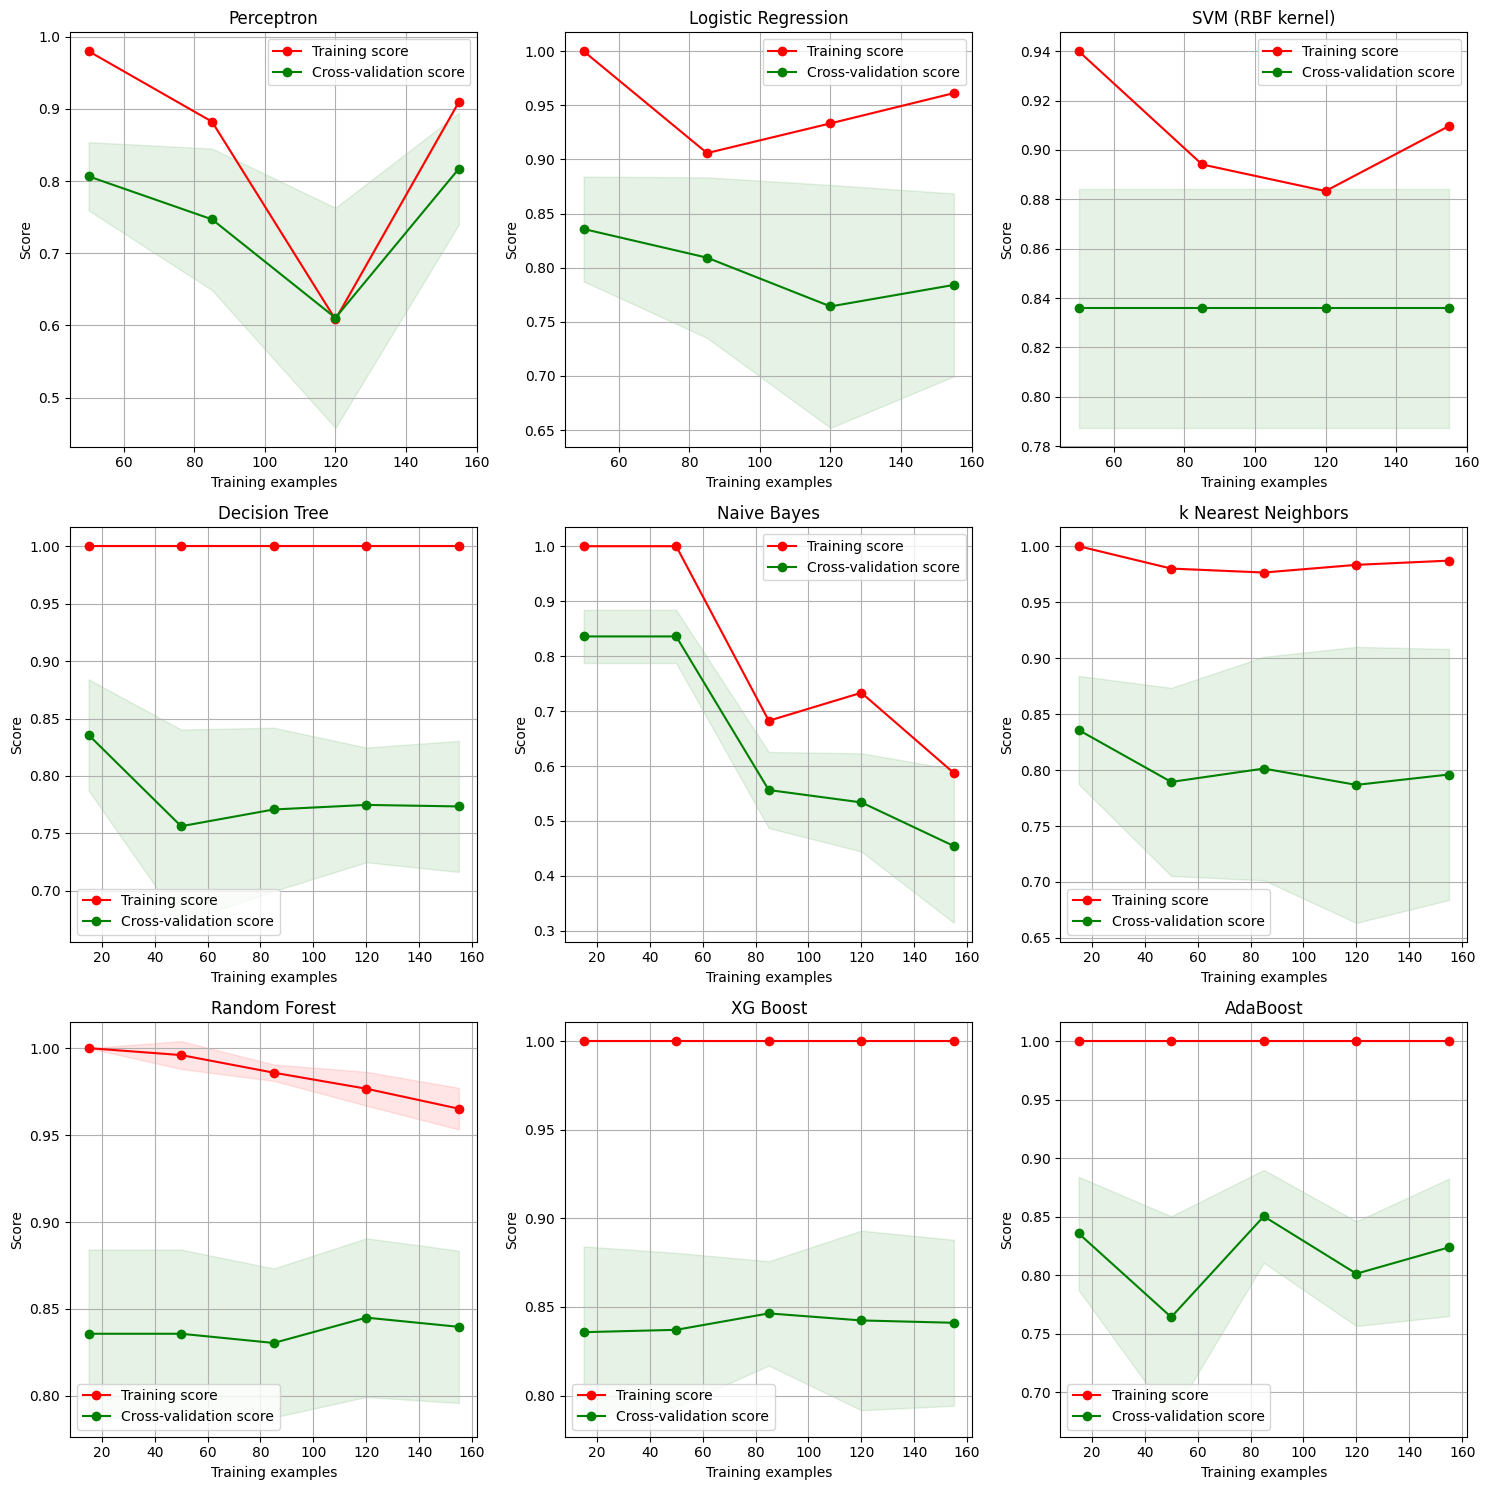

In [28]:
def plot_learning_curve(estimator, title, X, y, ax, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    ax.set_title(title)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.grid()
    ax.legend(loc="best")

plt.figure(figsize=(15, 15))

for i, (name, model) in enumerate(zip(names, classifiers), 1):
    ax = plt.subplot(3, 3, i)
    plot_learning_curve(model, name, X, y_new, ax=ax, cv=tscv, n_jobs=-1)

plt.tight_layout()
plt.show()


### Hyperparameter Gridsearch

In [29]:
# Define the parameter grid for XGBoost
param_grid_xgb = {
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.5],
    'xgbclassifier__n_estimators': [50,100,200],
    'xgbclassifier__max_depth': [3, 5, 7]
}

# Create the pipeline
pipeline_xgb = make_imblearn_pipeline(SMOTE(random_state=0),
                                     StandardScaler(),
                                      XGBClassifier(random_state=0, n_jobs=-1))
# Initialize the Grid Search model
grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid=param_grid_xgb, cv=tscv, scoring='roc_auc', n_jobs=-1)
# grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid=param_grid_xgb, cv=5, scoring='roc_auc', n_jobs=-1)
# Fit the model
grid_search_xgb.fit(X, y)

# Best parameters and best score
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)


Best parameters for XGBoost: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 100}


### Forecasting

In [30]:
model = XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, n_estimators=100, max_depth=5)
no_folds= 5
tscv = TimeSeriesSplit(n_splits=no_folds)
scoring = {'accuracy': 'accuracy', 'roc_auc': 'roc_auc', 'f1': 'f1', 'recall': 'recall'}
results = cross_validate(model, X_train_SMOTE_std, y_train_SMOTE, cv=tscv, scoring=scoring)

print(f"Mean Accuracy: {np.mean(results['test_accuracy'])}")
print(f"Mean AUC: {np.mean(results['test_roc_auc'])}")
print(f"Mean F1: {np.mean(results['test_f1'])}")
print(f"Mean Recall: {np.mean(results['test_recall'])}")

model.fit(X_train_SMOTE_std, y_train_SMOTE)
predictions = model.predict(X_test_std)
print(predictions)


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/zhengyuhan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/zhengyuhan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 399, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/Users/zhengyuhan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_ranking.py", line 572, in roc_auc_score
    return _average_binary_score(
  File "/Users/zhengyuhan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_base.py", line 75, in _average_binary_score
    return binary_metric(y_true, y_score, sample_weight=sample_weight)
  File "/Users/zhengyuhan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_ranking.py", line 339, in _binary_roc_auc_score
    raise V

Mean Accuracy: 0.8580912863070541
Mean AUC: nan
Mean F1: 0.7040529523807683
Mean Recall: 0.6328460966410009
[0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0]


In [31]:
features_encoded.loc[X_test.index, 'Prediction'] = predictions

In [32]:
positive_predictions = features_encoded[features_encoded['Prediction'] == 1]
print(positive_predictions)

    iso3      country  year  Banking Crisis iso2   imfn       si01       si02  \
74   AUT      Austria  2014             0.0   AT  122.0  26.820640   3.473374   
89   BEL      Belgium  2014             1.0   BE  124.0  14.365940   4.175692   
224  DNK      Denmark  2014             1.0   DK  128.0  18.400980   4.400791   
284  FIN      Finland  2014             0.0   FI  172.0   9.067446   1.297026   
299  FRA       France  2014             1.0   FR  132.0  16.620160   4.162499   
344  GRC       Greece  2014             1.0   GR  174.0   5.429644  14.818672   
389  ISL      Iceland  2014             1.0   IS  176.0   1.811674   2.025003   
434  ITA        Italy  2014             1.0   IT  136.0  12.984740  14.818672   
554  NLD  Netherlands  2014             1.0   NL  138.0   9.642394   2.982662   
599  NGA      Nigeria  2014             1.0   NG  694.0  16.441100   2.959538   
704  PRT     Portugal  2014             1.0   PT  182.0   9.327741  11.905709   
759  ESP        Spain  2014 

In [33]:
features_encoded[(features_encoded['Banking Crisis'] == 1)&(features_encoded['year'] == 2014)]

,iso3,country,year,Banking Crisis,iso2,imfn,si01,si02,si03,si04,si05,si06,si07,sm01,oi01,oi02,region_Europe & Central Asia,region_Latin America & Caribbean,region_Middle East & North Africa,region_North America,region_South Asia,region_Sub-Saharan Africa,income_Low income,income_Lower middle income,income_Upper middle income,si03_change,si04_change,si05_change,si06_change,oi02_change,Prediction
89,BEL,Belgium,2014,1.0,BE,124.0,14.365940,4.175692,6.627314,54.315350,17.577284,17.025210,40.425854,14.21778,88.86395,93.989040,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037148,-0.006128,-0.062174,-0.337480,0.000000,1.0
224,DNK,Denmark,2014,1.0,DK,128.0,18.400980,4.400791,7.310866,171.770900,18.209503,50.584430,41.382458,14.73483,81.00700,53.316640,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037035,0.000000,-0.028442,-0.029961,0.039654,1.0
299,FRA,France,2014,1.0,FR,132.0,16.620160,4.162499,5.282412,122.192000,16.348588,56.521340,51.052378,15.40628,61.14015,76.990050,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.092104,-0.024138,0.062675,0.000000,0.004126,1.0
344,GRC,Greece,2014,1.0,GR,174.0,5.429644,14.818672,8.061535,125.651700,14.069831,9.681284,55.730691,31.08751,76.52696,93.029620,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.067994,-0.008308,0.041582,0.000000,-0.004353,1.0
389,ISL,Iceland,2014,1.0,IS,176.0,1.811674,2.025003,12.120745,123.822100,18.742578,42.981710,86.119998,10.76594,92.51259,76.105080,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.974063,-0.130523,0.632629,-0.052086,0.011253,1.0
434,ITA,Italy,2014,1.0,IT,136.0,12.984740,14.818672,5.880693,114.074100,14.304929,30.749370,45.080546,20.86973,64.38723,77.569940,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.088135,-0.048959,0.044264,0.312311,0.025781,1.0
554,NLD,Netherlands,2014,1.0,NL,138.0,9.642394,2.982662,5.366743,113.610900,17.947769,39.531780,59.379999,12.72536,87.60651,93.989040,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.121829,-0.061471,0.205512,-0.129516,0.000000,1.0
599,NGA,Nigeria,2014,1.0,NG,694.0,16.441100,2.959538,10.423267,71.895020,18.560956,20.734520,64.425804,13.00287,40.00892,18.264030,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.002981,0.195806,0.084462,-0.195247,-0.036379,1.0
704,PRT,Portugal,2014,1.0,PT,182.0,9.327741,11.905709,6.441312,158.601100,12.254805,11.751650,63.981726,17.21034,84.76906,81.757430,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.048717,-0.076671,-0.079257,-0.327418,-0.003774,1.0
759,ESP,Spain,2014,1.0,ES,184.0,18.745630,8.452782,7.241612,134.142500,13.682656,18.752730,57.733482,18.04858,63.49393,93.989040,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066256,-0.121630,0.030376,-0.029972,0.000000,1.0


### Feature Explanation

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


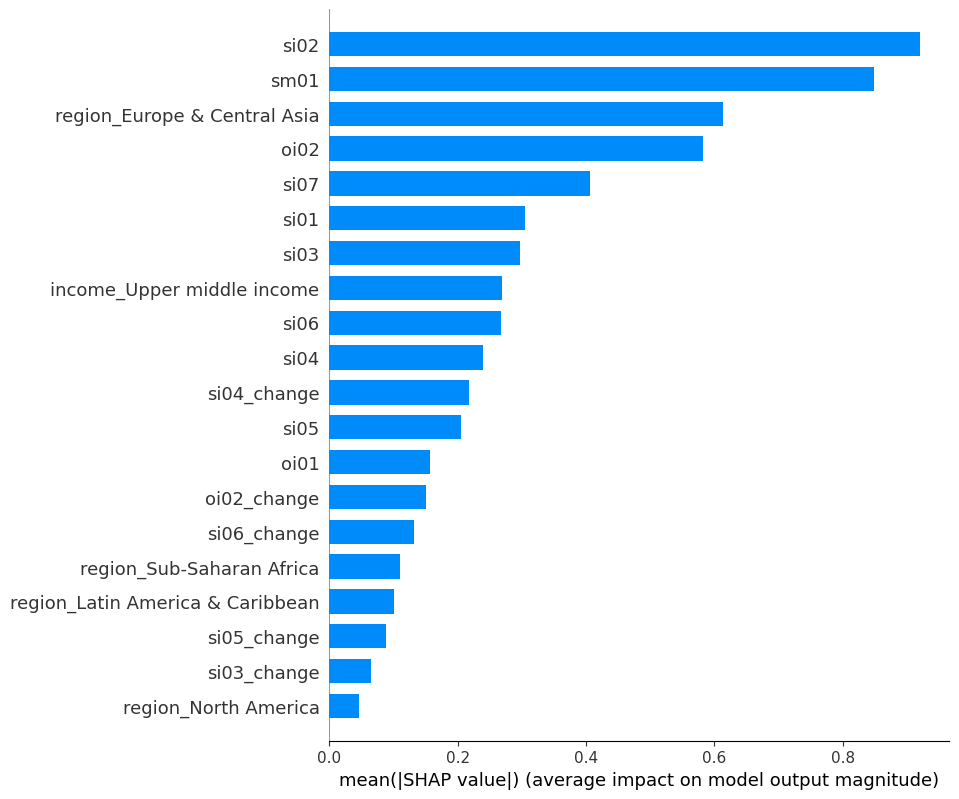

In [34]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_std)
shap.summary_plot(shap_values, X_test_std, plot_type='bar',feature_names=X.columns)

According to the Shapley value explanation, the factors `si02`, `sm01`, `region_European & Central Asian`,`oi02`,  `si07` are the five most related factors to banking crises. Among these five factors, `si02` and `sm01` are the most closely related to banking crises, followed by `region_European & Central Asian`, `oi02`, and `si07`.

## Communication

There are 62 missing values in variables `iso2`, 215 missing values in `Banking Crisis`, and more than 9000 each in the variables`si01-07`,`sm01`,`oi01-02`. It seems that most of the missing values in the variables`si01-07`,`sm01`,`oi01-02`come from before 2000 and after 2020. Missing values in the label `Banking Crisis` come from year 2015-2016, and two countries: Ireland and Switzerland. The `iso2` of Namibia, which is 'NA', was also wrongly recognized as missing value.

I drop the missing values in the label `Banking Crisis`, and fill in the missing value in `iso2`. Regarding the other varriables, I choose KNN imputation to address the missing values because KNN imputation is based on the principle of similarity. It assumes neighboring samples have similar feature values and can largely preserve the intrinsic relationships between sample.

Box plots indicate that outliers are predominantly concentrated at higher values. For instance, `si02`, `si04` ,`si07`, `si05` and `oi02` exhibit many high-end outliers. In contrast, `si05` have fewer outliers at the lower end. According to the Box plots, I chose limits=[0.02,0.1] for scipy.stats. mstats.winsorize function, meaning trimming the lowest 2% and highest 10% of the data points. After trimming, the outliers are removed from the dataframe.

In the feature engineering part, for the current scenario, encoding region and income with OneHotEncoder is chosen because these features are unordered, and I want to retain the information in these features without introducing potential assumptions of order. I think this is helpful for most tree-based models and linear models, as they do not inherently interpret mathematical operations between categories.

I also removed 'country' and 'year' from model training data. It is under the consideration of generalization and interpretability. These fields can increase noise and limit the model's ability to apply learned patterns to new, unseen data. One-hot encoding 'country' inflates the number of features, complicating training and adding minimal information. Predictions also become less understandable when tied to specific countries or years rather than broader trends or indicators.

The primary metric chosen is ROC-AUC score, because it considers both the sensitivity of the model (recall) and the specificity (the ability to correctly identify non-crisis situations). XGBoost is selected as the model due to its superior performance in metrics and its ability to mitigate overfitting. For the cross-validation method, taking into account time continuity and potential trend changes, I chose TimeSeriesSplit to assess the average performance metrics of the model across different time periods. 

When analyzing financial and macroeconomic data that related to time series analysis, changes in variables are important.  Rates of change may include more valuable information than absolute values, as they reflect dynamic shifts in economic indicators. The deterioration of the asset quality and the excessive exposure to risky assets, along with low bank liquidity, were strongly related to both the 2007-2008 Global Financial Crisis and the 2010-2012 European Debt Crisis. A positive value in the change rate may happend before the Banking Crisis. I added the percentage change of the following variables `si03`, `si04` ,`si05`, `si06` and `oi02`. After adding these new variables, the AUC score enhanced by 0.06, F1 and accuracy enhanced by 0.18 and 0.22.

Based on the data coverage analysis, the period from 2000 to 2014 appears to have the fewest missing values. However, it is important to take the occurrence of some important crisis such as the Latin American debt crisis of the 1980s and the Asian Crisis of 1997 into consideration for the time spans. Therefore, in the model building phase, I controlled the time period selection. Initially, I tried the time span from 2000 to 2014, which achieved an AUC score of 0.684 and a recall of 0.451. I also experimented with the time spans of 1995-2014 and 1980-2024, but both showed weaker performance with an AUC score of 0.680 and 0.592.

There is a significant imbalance issue in the labels, with 772 instances labeled as '0' and 130 instances labeled as '1'. As an initial attempt to address the imbalance issue, I first removed 400 instances with a label of '0'. However, this resulted in poor performance, with an AUC of only 0.676. Therefore, alternative approaches for generating new data points are being explored. In the second attempt, I introduced SMOTE (Synthetic Minority Class Oversampling) on the training data, which achieved an 0.08 increase in AUC and 0.36 incease in accuracy.


Consequently, the model utilized a sample ranging from 2014 to 2020, incorporating cross-validation and SMOTE techniques, excluding the sample related to year and country name, as well as including five other variables representing percentage changes: `si03_change`, `si04_change`, `si05_change`, `si06_change`, and `oi02_change`. In the test dataset, there were 11 samples labeled as '1', of which the model successfully predicted 10. However, it misclassified two samples labeled as '0' as '1', which are Australia and Finland, and it failed to correctly predict one sample, which is England.


Based on the explanation of the Shapley value, the top 5 factors that may have contributed to the banking crisis are `si02`, `sm01`, `region_European & Central Asian`,`oi02`,  `si07`. Among these factors,  `si02` and `sm01` have the strongest correlation with the banking crisis, followed by `region_European & Central Asian`,`oi02`, and`si07`. This implies that countries facing high stock price volatility, significant nonperforming loans, a high ratio of bank deposits to GDP, and particularly those located in the European & Central Asian region are more likely to experience a banking crisis.

In a more comprehensive model, I think it's important to take this time series effect into account when building the machine learning model. Some indicator,such as Bank deposits to GDP (%),Bank regulatory capital to risk-weighted assets (%), may peak before the Banking cirsis and be treated as an leading indicator, while some indicator may reveal lagging effect in predicting the Banking cirsis.  One can observe the fluctuations of these indicators before and after banking crises using a sliding window, and then analyze the temporal relationship between the indicators and banking crises using ACF and PACF. If the data exhibits strong time series characteristics, one may also try LSTM networks or other types of RNNs.